In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import matplotlib
import pyrosetta as pr
pr.init("-mute core basic protocols")
matplotlib.rcParams["figure.figsize"] = (15,15)

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python37.linux 2019.45+release.fc8ab401178f6f099884fd5a39597b1a9cac8db2 2019-11-05T15:46:43] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [2]:
dirname = ""
protein_names = [x.split(".")[0] for x in os.listdir(dirname + "contacts")]
bins = np.arange(4,43.0,0.5)


def show_matrix(protein,mask_short=False,mask_middle=False):
        n = max([
            len(protein.sequence), 
            int(protein.contacts["i"].max()), 
            int(protein.contacts["j"].max()), 
            int(protein.xl_sulfo["i"].max()),
            int(protein.xl_sulfo["j"].max()),
            int(protein.xl_photoAA["i"].max()),
            int(protein.xl_photoAA["j"].max()),
        ])
        
        im = np.zeros((n, n))
        ind = protein.contacts[["i", "j"]].values.astype(np.int32) - 1
        values = protein.contacts["p"].values
        im[ind[:,0],[ind[:,1]]] = values
        im[ind[:,1],[ind[:,0]]] = values
        
        if mask_short:
            print(ind.shape)
            too_short = ((ind[:,0] - ind[:,1]) < 12)
            ind_short = ind[too_short,:]
            im[ind_short[:,0],[ind_short[:,1]]] = 0.0
            im[ind_short[:,1],[ind_short[:,0]]] = 0.0
        
        if mask_middle:
            print(ind.shape)
            middle = ((ind[:,0] - ind[:,1]) >= 12)
            middle = ((ind[:,0] - ind[:,1]) <= 23)
            ind_m = ind[middle,:]
            im[ind_m[:,0],[ind_m[:,1]]] = 0.0
            im[ind_m[:,1],[ind_m[:,0]]] = 0.0
        
        
        #sulfo = protein.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1 
        #plt.scatter(sulfo[:,0], sulfo[:,1], color="blue", label="Sulfo")
        #plt.scatter(sulfo[:,1], sulfo[:,0], color="blue")

        photoAA = protein.xl_photoAA[["i", "j"]].values.astype(np.int32) - 1
        plt.scatter(photoAA[:,0], photoAA[:,1], color="red", label="photoAA")
        plt.scatter(photoAA[:,1], photoAA[:,0], color="red")
        plt.legend()
        plt.imshow(im, cmap="gray")
        plt.colorbar()

class Protein:
    
    def __init__(self, dirname, name):
        self.name = name
        self.native = pr.io.pose_from_pdb(dirname + "pdb/" + name + ".pdb")
        self.sequence = self.native.sequence()
        self.contacts = pd.read_csv(dirname + "contacts/" + name + ".contacts", sep=" ", names=["i", "j", "_1", "_2", "p"])[["i", "j", "p"]]
        self.xl_photoAA = pd.read_csv(dirname + "photoAA_xl/" + name + "_FDR10", sep=" ", names=["i", "j"])
        self.xl_sulfo = pd.read_csv(dirname + "sulfo-SDA_xl/" + name + ".xl", sep=" ", names=["i", "j"])
        self.dist = np.load(dirname + 'distograms/' + name + '.npz')
        self.distogram = self.dist["distogram"]
        self.ss = self.dist["ss"]
        
    def __repr__(self):
        return self.name
    
    
    def get_crosslink_distributions(self, lower, upper, thresh=0.8):
        close = np.logical_and(bins < upper,  bins > lower)
        mask = np.argwhere(self.distogram[close].sum(axis=0) > thresh)        
        close_hists = self.distogram[:, mask[:,0],mask[:,1]]
        return close_hists
        


            
    

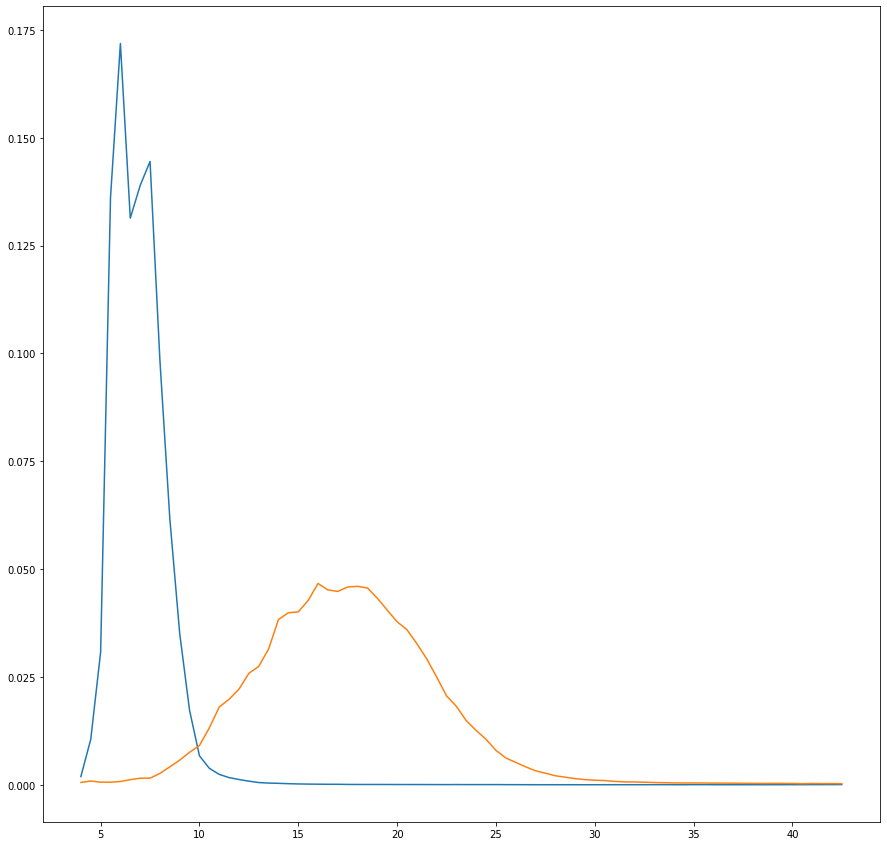

In [3]:
photoAA = [Protein(dirname, protein_names[i]).get_crosslink_distributions(5, 10) for i in range(len(protein_names))]
plt.plot(bins, np.hstack(photoAA).mean(axis=1))
sulfo = [Protein(dirname, protein_names[i]).get_crosslink_distributions(10, 25) for i in range(len(protein_names))]
plt.plot(bins, np.hstack(sulfo).mean(axis=1))

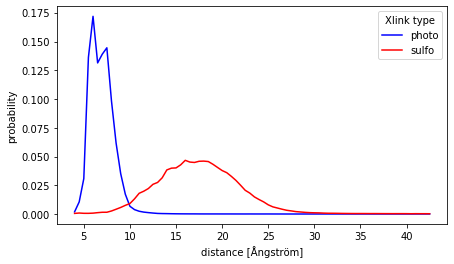

In [10]:
plt.figure(figsize=(7,4))
plt.plot(bins, np.hstack(photoAA).mean(axis=1),label='photo', c='blue')
plt.plot(bins, np.hstack(sulfo).mean(axis=1), label='sulfo', c='red')
plt.xlabel('distance [Ångström]')
plt.ylabel('probability')
plt.legend(title='Xlink type')

In [8]:
np.save("dist_close", np.hstack(photoAA).mean(axis=1))
np.save("dist_medium", np.hstack(sulfo).mean(axis=1))